In [124]:
from SALib.sample import saltelli
from SALib.sample import latin
from SALib.analyze import sobol
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
import numpy as np
import scipy as sp # for inverse CDF (ppf) function for distributions
import matplotlib.pyplot as plt

In [125]:
# Define Sarah's rhythmic mRNA degradation model

def Sarah_rhythmic_mRNA(par):
    model_output = np.zeros(3)
    
    # simulation time interval
    t = np.linspace(0,700,701)
    # intial value
    x0 = 0;

    sol = odeint(ode_model,x0,t,args=(par,))
    # cubic interpolation 

    spl = CubicSpline(t,sol)
    t_int = np.linspace(600,648,2000)
    sol_int = spl(t_int)
    
    maxss = max(sol_int)
    minss = min(sol_int)
    
    t_max = np.argmax(sol_int)
    phase = t_int[t_max]
    # calculate total mRNA rhythmicity
    model_output[0] =  np.mean(sol_int);
    model_output[1] = (maxss-minss)/(maxss+minss)
    model_output[2] = np.mod(phase,24)*2*np.pi/24
    
    
    '''
    # plot
    plt.plot(t,sol,'--',label='ode sol')
    plt.scatter(t_int,sol_int,s=2*np.ones(len(t_int)),color='red',label='cubic interpolation')
    plt.scatter(phase,maxss,s=50,marker='^',color='green',label='peak phase')
    plt.grid()
    plt.xlim([600,648])
    plt.xlabel('phase(h)')
    plt.ylabel('[mRNA]')
    plt.legend()
    plt.show()
    '''
    return model_output[0],model_output[1],model_output[2]
    #return model_output

# ODE model of rhythmic mRNA degradation
def ode_model(x,t,p):

    Atrsc, Ptrsc, Kdgrd, Adgrd, Pdgrd = p

    omg = 2*np.pi/24

    Ktrsc = 1

    dxdt = Ktrsc*(1+Atrsc*np.cos(omg*(t-Ptrsc)))-Kdgrd*(1+Adgrd*np.cos(omg*(t-Pdgrd)))*x
    
    return dxdt

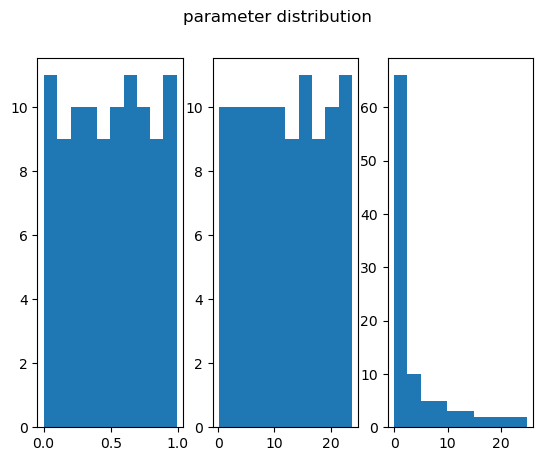

In [126]:
# Define the Model inputs distribution
problem = {
    'num_vars': 5,
    'names': ['Atrsc', 'Ptrsc', 'Kdgrd', 'Adgrd','Pdgrd'],
    'bounds': [[0, 1],
               [0, 24],
               [-1.58, 1.415],
               [0, 1],
               [0, 24]],
    'dists':['unif','unif','unif','unif','unif'],
    #'outputs': ['mean','amplitude','phase']
}

sample_size = 10**2
param_values = latin.sample(problem, sample_size)
#saltelli_param_values = saltelli.sample(problem, sample_size)
# be careful of the usage of Sobol sequence, details in the discussion 
# UserWarning: 
#        Convergence properties of the Sobol' sequence is only valid if
#        `N` (10000) is equal to `2^n`.

# use inverse CDF to transform Kd distribution
param_values[:,2] = 10**param_values[:,2]

# Kd distribution created in MATLAB
# Kd_pd_log= makedist('Uniform','lower',-1.58,'upper',1.415);
# Kd_pd = 10.^random(Kd_pd_log,[size,1]);


# plot the distribution of model parameters
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.suptitle('parameter distribution')
ax1.hist(param_values[:,0])
ax2.hist(param_values[:,1])
ax3.hist(param_values[:,2])
plt.show()

In [127]:
# Run Sarah model
Y = np.array([Sarah_rhythmic_mRNA(par) for par in param_values])

In [128]:
# Sobol analysis for each output
y = Y.T
sobol_indices = sobol.analyze(problem, y[:,2],calc_second_order=False)

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

In [ ]:
sobol_indices[2].plot()

In [ ]:
param_values.shape

In [ ]:
y.shape

In [ ]:
type(y[:,2])